In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Pair counts DECaLS DR9

The directory `/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/` contains the pair counts files for DECaLS DR9. The Randoms have been sliced up into 16 equal samples, that means we have 16 `RR` paircounts, 16 `DR` paircounts and 1 `DD` paircounts. These paircounts are stored in the form of a python dictionary, the 16 `RR` are here `RR_south_16.npy` while `DD` and the 16 `DR` paircounts are here `DD_DR_decals_16_*.npy`. There's one file per colour bin in`g-r`, so for instance, for the bin $0.5 < g-r < 0.75$ file is called `DD_DR_decals_16_0.5_0.75.npy`). I've done the same for `MXXL` catalogue, the `DD` and the 16 `DR` paircounts are here `DD_DR_decals_16_*_MXXL.npy`. Note that I used the Random catalogue without applying the spatial BGS cuts (i.e. it has no holes).

Below I have included an example to read and stack these files to compute the angular clustering with the Hamilton estimator,


$\omega(\theta)_{H} = \frac{N_{dd} \cdot n \cdot \sum_{i}^{35} N_{rr}}{\sum_{i}^{35} N_{dr}^2} -1.$


In [10]:
#
colours = []
val = np.array([0, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0])#
for num, i in enumerate(val[:-1]):
    colours.append('%s_%s' %(str(val[num]), str(val[num+1])))


In [20]:
#
def read_clustering(mxxl=False):
    
    ac = {}

    ran_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/RR_south_16.npy'
    #ran_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/RR_0.0_0.5_2.npy'
    ran = np.load(ran_file, allow_pickle=True).item()

    for num, key in enumerate(colours):

        if mxxl:
            DD_DR_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/DD_DR_decals_16_%s_MXXL.npy' %(key)
        else:
            DD_DR_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/DD_DR_decals_16_%s.npy' %(key)
            
        DD_DR = np.load(DD_DR_file, allow_pickle=True).item()
        
        w = []
        bc = []

        DD_ = DD_DR['DD_%s' %(key)]
        DD = []

        for i in range(len(DD_)):

            DD.append(DD_[i][3])

        DR = np.full(len(DD_), 0)
        RR = np.full(len(DD_), 0)

        for keyR in range(len(ran)):
            #ni = len(randoms)/len(val)
            ni = len(ran)
            for i in range(len(DD)):

                DR[i] += DD_DR['DR_%s_%s' %(key, keyR)][i][3]
                RR[i] += ni * ran['RR_%s' %(keyR)][i][3]
            #print('%s: \t %f' %(keyR, len(randoms)/len(val)))

        ac['RR'] = RR
        if num < 1:
            halfbin = (DD_[0][1] - DD_[0][0])/2.

            for i in range(len(DD)):

                bc.append(np.array(DD_[i][0]) + halfbin)

            ac['bs'] = bc

        ac['w_%s' %(key)] = ((np.array(DD) * RR)/DR**2) - 1
        
    return ac
    

In [22]:
#get angular clustering for BGS catalogue
ac_bgs = read_clustering(mxxl=False)
#get angular clustering for MXXL catalogue
ac_mxxl = read_clustering(mxxl=True)

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 <a list of 7 Text yticklabel objects>)

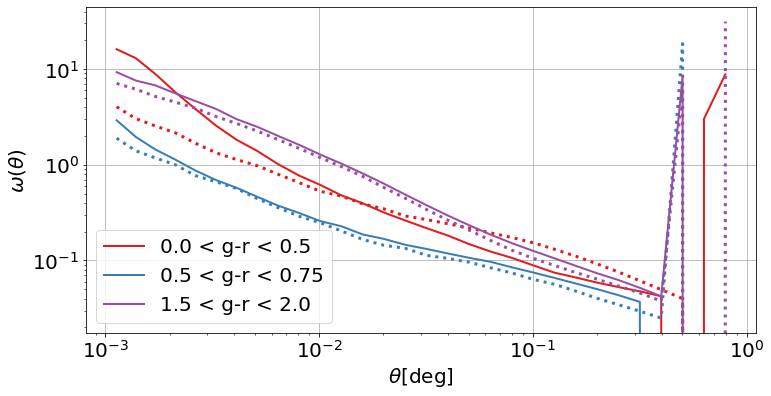

In [24]:
#
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(12,6))
color=cm.Set1(np.linspace(0,1,len(colours)))

#
N = 30

# clist = ['0.0_0.5', '0.5_0.75', '0.75_1.0', '1.0_1.25', '1.25_1.5', '1.5_2.0']
clist = ['0.0_0.5', '0.5_0.75', '1.5_2.0']
#cmap = plt.get_cmap('jet', len(clist))
for num, key in enumerate(clist):
    
    ini, fin = key.split('_')
    
    plt.loglog(ac_bgs['bs'][:N], ac_bgs['w_%s' %(key)][:N], lw=2, color=color[num], label='%s < g-r < %s' %(ini, fin))
    plt.loglog(ac_mxxl['bs'][:N], ac_mxxl['w_%s' %(key)][:N], lw=3, color=color[num], ls=':')

    #plt.legend(bbox_to_anchor=(1.1, 1.05))
    
plt.xlabel(r'$\theta$[deg]', fontsize=20)
plt.ylabel(r'$\omega(\theta)$', fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#filefig = os.path.join('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/figures/', 'angular_clustering_color_bgs_mxxl')
#fig.savefig(filefig+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)
